In [1]:
import sys
sys.path.insert(0, "..")

import numpy as np
import matplotlib.pyplot as plt
import torch
from torch.nn import functional as F
import pickle
import time 

print(f"Cuda available: {torch.cuda.is_available()}")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

from app.vjepa_droid.transforms import make_transforms
from utils.mpc_utils import compute_new_pose

# Good pickle files to use:
# 1753840418
# 1753840146 (frame 35)
# 1753913339 (with state data)

# Load ManiSkill demo pickle file
pickle_path = '/data/maddie/predictive_safety_filters/demos/coffee_table/keyboard/1753840146.pickle'
with open(pickle_path, 'rb') as f:
    data = pickle.load(f)

print("Loaded keys:", data.keys())
print("Last 10 actions:", data["actions"][10:])


Cuda available: True
Loaded keys: dict_keys(['state_dict', 'actions', 'images'])
Last 10 actions: [tensor([0., 0., 0., 0., 0., 0., 1.]), tensor([0., 0., 0., 0., 0., 0., 1.]), tensor([0., 0., 0., 0., 0., 0., 1.]), tensor([0., 0., 0., 0., 0., 0., 1.]), tensor([0., 0., 0., 0., 0., 0., 1.]), tensor([0., 0., 0., 0., 0., 0., 1.]), tensor([0., 0., 0., 0., 0., 0., 1.]), tensor([0., 0., 0., 0., 0., 0., 1.]), tensor([0., 0., 0., 0., 0., 0., 1.]), tensor([0., 0., 0., 0., 0., 0., 1.]), tensor([0., 0., 0., 0., 0., 0., 1.]), tensor([0., 0., 0., 0., 0., 0., 1.]), tensor([0., 0., 0., 0., 0., 0., 1.]), tensor([0., 0., 0., 0., 0., 0., 1.]), tensor([0., 0., 0., 0., 0., 0., 1.]), tensor([0., 0., 0., 0., 0., 0., 1.]), tensor([0., 0., 0., 0., 0., 0., 1.]), tensor([0., 0., 0., 0., 0., 0., 1.]), tensor([0., 0., 0., 0., 0., 0., 1.]), tensor([0., 0., 0., 0., 0., 0., 1.]), tensor([0., 0., 0., 0., 0., 0., 1.]), tensor([0., 0., 0., 0., 0., 0., 1.]), tensor([0., 0., 0., 0., 0., 0., 1.]), tensor([0., 0., 0., 0., 0.,

In [2]:

rate = 15  # Convert 60 FPS to 4 FPS

# Downsampled version of data
downsampled_data = {
    "state_dict": data["state_dict"],
    "actions": data["actions"][::rate],
    "images": data["images"][::rate],
}

print("Downsampled #frames:", len(downsampled_data['images']))
print("Example image shape:", downsampled_data['images'][0][0][0].shape)

Downsampled #frames: 45
Example image shape: (512, 512, 3)



Action at t=35: tensor([ 0.0000, -0.0500,  0.0500, -0.1000,  0.0000,  0.0000, -1.0000])


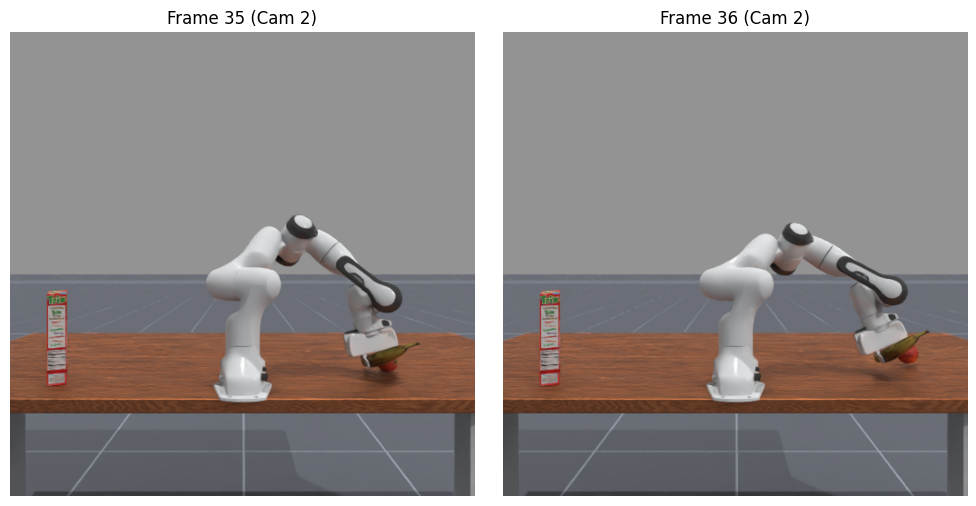

In [3]:
# ------------------------------
# 🎞️ Visualize Original Frames
# ------------------------------
camera_idx = 2
t_curr = 35

print(f"\nAction at t={t_curr}:", downsampled_data['actions'][t_curr])

fig, axs = plt.subplots(1, 2, figsize=(10, 5))
axs[0].imshow(downsampled_data['images'][t_curr][camera_idx][0])
axs[0].set_title(f"Frame {t_curr} (Cam {camera_idx})")
axs[1].imshow(downsampled_data['images'][t_curr+1][camera_idx][0])
axs[1].set_title(f"Frame {t_curr+1} (Cam {camera_idx})")
for ax in axs: ax.axis('off')
plt.tight_layout(); plt.show()

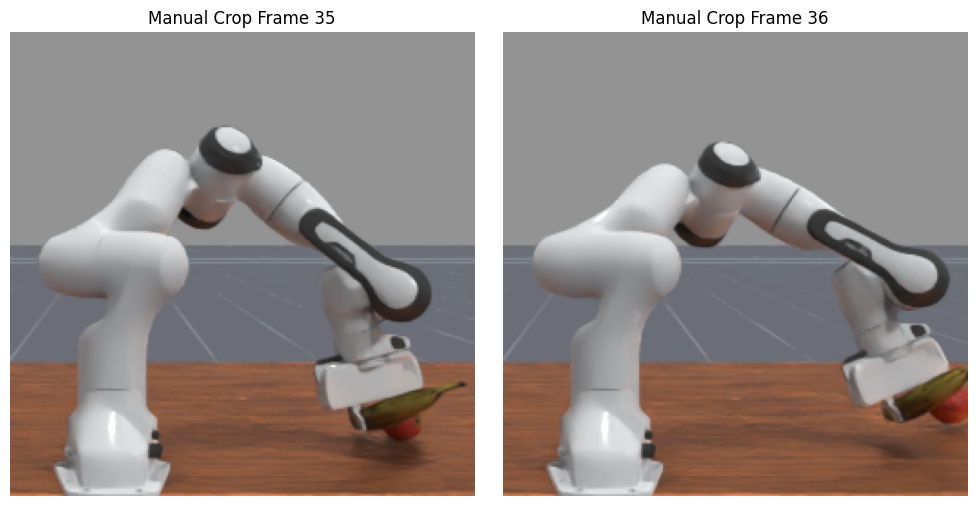

In [4]:
# ------------------------------
# ✂️ Manual Crop to 256x256
# ------------------------------

def manual_crop(img, top, left, crop_size=256):
    return img[top:top+crop_size, left:left+crop_size]

crop_size = 256
left, top = 200, 150  # Tune for visibility

frame_t = downsampled_data['images'][t_curr][camera_idx][0]
frame_t1 = downsampled_data['images'][t_curr+1][camera_idx][0]
frame_t_cropped = manual_crop(frame_t, top=top, left=left, crop_size=crop_size)
frame_t1_cropped = manual_crop(frame_t1, top=top, left=left, crop_size=crop_size)

# Visualize cropped
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
axs[0].imshow(frame_t_cropped)
axs[0].set_title(f"Manual Crop Frame {t_curr}")
axs[1].imshow(frame_t1_cropped)
axs[1].set_title(f"Manual Crop Frame {t_curr+1}")
for ax in axs: ax.axis('off')
plt.tight_layout(); plt.show()

In [5]:
# ------------------------------
# 🧹 Preprocess for V-JEPA 2
# ------------------------------

np_imgs = np.stack([frame_t_cropped, frame_t1_cropped], axis=0)  # [2, H, W, C]
tensor_imgs = torch.tensor(np_imgs, dtype=torch.float32) / 255.0  # Normalize to [0,1]
tensor_imgs = tensor_imgs.permute(3, 0, 1, 2)  # [3, 2, H, W]
clips = tensor_imgs.unsqueeze(0)  # [1, 3, 2, 256, 256]

print("Input tensor shape:", clips.shape)

Input tensor shape: torch.Size([1, 3, 2, 256, 256])


In [6]:
# ------------------------------
# 🤖 Prepare Action + Dummy State
# ------------------------------
'''
You can use a dummy state for testing purposes. 
This works if you don't need to predict the physical pose.
If you use a dummy state you will only be able to predict the visual features of the next frame.
'''

t_curr = 34  # update t_curr before cropping and action
action = torch.tensor(downsampled_data["actions"][t_curr], dtype=torch.float32).unsqueeze(0).unsqueeze(0)  # [1,1,7]
dummy_state = torch.zeros((1, 1, 7), dtype=torch.float32)

print("Action:", action)
print("Dummy state shape:", dummy_state.shape)

Action: tensor([[[-0.0500, -0.0500,  0.0000, -0.1000,  0.0000,  0.0000, -1.0000]]])
Dummy state shape: torch.Size([1, 1, 7])


/tmp/ipykernel_227037/1846554466.py:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  action = torch.tensor(downsampled_data["actions"][t_curr], dtype=torch.float32).unsqueeze(0).unsqueeze(0)  # [1,1,7]


In [7]:
# ------------------------------
# 🔌 Load V-JEPA 2 Model
# ------------------------------

encoder, predictor = torch.hub.load("facebookresearch/vjepa2", "vjepa2_ac_vit_giant")
encoder = encoder.to(device)
predictor = predictor.to(device)
clips = clips.to(device)
action = action.to(device)
dummy_state = dummy_state.to(device)

Using cache found in /home/maddie/.cache/torch/hub/facebookresearch_vjepa2_main
/home/maddie/.conda/envs/vjepa2/lib/python3.12/site-packages/timm/models/layers/__init__.py:48: FutureWarning: Importing from timm.models.layers is deprecated, please import via timm.layers
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.layers", FutureWarning)


In [8]:
# ------------------------------
# Define tokens_per_frame
# ------------------------------
patch_size = encoder.patch_size  # usually 16
tokens_per_frame = (crop_size // patch_size) ** 2
print(f"Patch size: {patch_size}, Tokens per frame: {tokens_per_frame}")

Patch size: 16, Tokens per frame: 256


In [9]:
# ------------------------------
# 🧠 Define Encoding step, predicting step, and L1 Loss functions
# ------------------------------

def forward_target(c, normalize_reps=True):
    B, C, T, H, W = c.size()
    c = c.permute(0, 2, 1, 3, 4).flatten(0, 1).unsqueeze(2).repeat(1, 1, 2, 1, 1)
    h = encoder(c)
    h = h.view(B, T, -1, h.size(-1)).flatten(1, 2)
    if normalize_reps:
        h = F.layer_norm(h, (h.size(-1),))
    return h

def step_predictor(z_hat, a_hat, s_hat, normalize_reps=False):
    z_hat = predictor(z_hat, a_hat, s_hat)[:, -tokens_per_frame:]
    if normalize_reps:
        z_hat = F.layer_norm(z_hat, (z_hat.size(-1),))
    s_hat = compute_new_pose(s_hat[:, -1:], a_hat[:, -1:])
    return z_hat, s_hat

def loss_fn(z, h):
    """
    Compute the L1 Loss (Average Absolute Error) between predicted and target latent tokens.
    """
    z, h = z[:, -tokens_per_frame:], h[:, -tokens_per_frame:]
    return torch.mean(torch.abs(z - h), dim=[1, 2])



In [10]:
# ------------------------------
# 🔮 Encode, Predict
# ------------------------------

# start tracking time it takes to encode and predict
start_time = time.time()

# Encode visual context and split
h = forward_target(clips)  # encode the input clips (frame_t and frame_t+1)

# predict next latent tokens
z_next_pred, _ = step_predictor(h[:, :tokens_per_frame], action, dummy_state)

# end tracking time it takes to encode and predict
end_time = time.time()
print(f"Prediction time: {end_time - start_time:.4f} seconds")


Prediction time: 0.3467 seconds


/home/maddie/.conda/envs/vjepa2/lib/python3.12/contextlib.py:105: FutureWarning: `torch.backends.cuda.sdp_kernel()` is deprecated. In the future, this context manager will be removed. Please see `torch.nn.attention.sdpa_kernel()` for the new context manager, with updated signature.
  self.gen = func(*args, **kwds)


In [11]:
# ------------------------------
# 📉 Evaluate
# ------------------------------

# L1 Loss: Measures how far the predicted latent tokens are from the ground truth in raw numbers.
loss = loss_fn(z_next_pred, h[:, tokens_per_frame:])
print(f"\n Prediction L1 Loss: {loss.item():.4f}")

# Cosine Similarity: Measures angular similarity between predicted and true tokens.
cos_sim = F.cosine_similarity(z_next_pred, h[:, tokens_per_frame:], dim=-1).mean().item()
print(f"\n Cosine Similarity: {cos_sim:.4f}")

print(f"\n Cannot compute MSE loss becuase we dont have access to the state")



 Prediction L1 Loss: 0.5630

 Cosine Similarity: 0.7072

 Cannot compute MSE loss becuase we dont have access to the state


# 🧠 Understanding Tokens in Vision Transformers (ViT) and V-JEPA 2

## 🔍 What Are "Tokens" in a Vision Transformer?

In a Vision Transformer (ViT), such as the one used in **V-JEPA 2**, an image is not processed pixel-by-pixel.
Instead, the image is split into smaller square regions called **patches**, and each patch is treated as a **token**, similar to a word token in NLP.

---

## 🖼️ What Is a Frame?

* A **frame** is a single image captured at one moment in time.
* The **V-JEPA encoder** takes in **two frames**:

  * `frame_t` (the current image)
  * `frame_t+1` (the next image)
* Each frame is split into patches of size `patch_size = 16`.

For a `256 × 256` image:

```
(256 / 16) × (256 / 16) = 16 × 16 = 256 patches
```

So:

* **Each frame becomes 256 tokens**
* **Two frames produce 512 tokens in total**

---

## 🌟 Goal of Prediction

We want to **predict the tokens of frame `t+1`** using:

* The **tokens from frame `t`**
* The **action** the robot took between `t` and `t+1`
* (Optionally) the robot’s **state**

---

## 📦 The Token Tensor `h`

After passing two frames into the V-JEPA encoder, we get:

```python
h.shape = [1, 512, 1408]
```

Where:

* `1` = batch size
* `512` = total number of tokens (256 from each frame)
* `1408` = token embedding dimension

So:

* The **first 256 tokens** in `h` correspond to **frame `t`**
* The **next 256 tokens** in `h` correspond to **frame `t+1`**

---

## 🧠 Extracting Tokens from Each Frame

### Frame `t` tokens

```python
z_t = h[:, :tokens_per_frame]
```

* `:` → select all batches
* `:tokens_per_frame` → select tokens 0 to 255
* This gives the **embedding of frame `t`**

### Frame `t+1` tokens

```python
h_t1 = h[:, tokens_per_frame:]
```

* `tokens_per_frame:` → select tokens 256 to 511
* This gives the **embedding of frame `t+1`**

---

## 📌 Summary

* **Token** = patch of the image
* **1 frame** → 256 tokens
* **2 frames** → 512 tokens
* `h` contains all tokens

  * First 256: frame `t`
  * Next 256: frame `t+1`
* Use `z_t = h[:, :tokens_per_frame]` and `h_t1 = h[:, tokens_per_frame:]` to split them cleanly


Using cache found in /home/maddie/.cache/torch/hub/facebookresearch_vjepa2_main
/tmp/ipykernel_227037/3317509838.py:66: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  action = torch.tensor(actions[t], dtype=torch.float32).view(1, 1, 7).to(device)


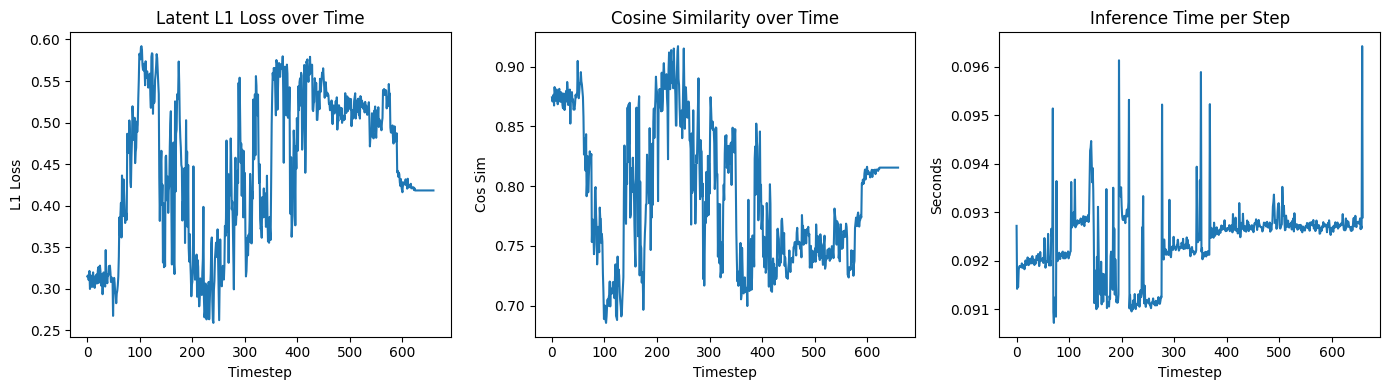

In [12]:
import torch
import numpy as np
import time
import matplotlib.pyplot as plt
from torch.nn import functional as F

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load V-JEPA 2 model
encoder, predictor = torch.hub.load("facebookresearch/vjepa2", "vjepa2_ac_vit_giant")
encoder = encoder.to(device)
predictor = predictor.to(device)

# Preprocessing transform
crop_size = 256
tokens_per_frame = int((crop_size // encoder.patch_size) ** 2)
from app.vjepa_droid.transforms import make_transforms
transform = make_transforms(
    random_horizontal_flip=False,
    random_resize_aspect_ratio=(1., 1.),
    random_resize_scale=(1., 1.),
    reprob=0.,
    auto_augment=False,
    motion_shift=False,
    crop_size=crop_size,
)

# Loss fn
def loss_fn(z, h):
    z, h = z[:, -tokens_per_frame:], h[:, -tokens_per_frame:]
    return torch.mean(torch.abs(z - h), dim=[1, 2]).tolist()

# V-JEPA forward
def forward_target(c, normalize_reps=True):
    B, C, T, H, W = c.size()
    c = c.permute(0, 2, 1, 3, 4).flatten(0, 1).unsqueeze(2).repeat(1, 1, 2, 1, 1)
    h = encoder(c)
    h = h.view(B, T, -1, h.size(-1)).flatten(1, 2)
    if normalize_reps:
        h = F.layer_norm(h, (h.size(-1),))
    return h

def step_predictor(z_hat, a_hat, s_hat=None, normalize_reps=False):
    z_hat = predictor(z_hat, a_hat, torch.zeros_like(a_hat))[:, -tokens_per_frame:]  # use dummy state
    if normalize_reps:
        z_hat = F.layer_norm(z_hat, (z_hat.size(-1),))
    return z_hat

# -------------------------------
# Load data
import pickle
with open("/data/maddie/predictive_safety_filters/demos/coffee_table/keyboard/1753840146.pickle", "rb") as f:
    data = pickle.load(f)

images = data["images"]
actions = data["actions"]
cam_idx = 2  # choose the camera you want

# -------------------------------
# Evaluate all (t, t+1) image-action pairs
results = []

for t in range(len(actions) - 1):
    img_t = images[t][cam_idx][0]       # [H, W, C]
    img_t1 = images[t+1][cam_idx][0]    # [H, W, C]
    action = torch.tensor(actions[t], dtype=torch.float32).view(1, 1, 7).to(device)

    # Manually crop if needed (e.g., 200,150 top-left)
    top, left = 150, 200
    def crop(img): return img[top:top+256, left:left+256]

    img_pair = np.stack([crop(img_t), crop(img_t1)], axis=0)   # [2, H, W, C]
    tensor_imgs = torch.tensor(img_pair, dtype=torch.float32) / 255.
    tensor_imgs = tensor_imgs.permute(3, 0, 1, 2).unsqueeze(0).to(device)  # [1, 3, 2, 256, 256]

    with torch.no_grad():
        start = time.time()
        h = forward_target(tensor_imgs)
        z0, z1 = h[:, :tokens_per_frame], h[:, tokens_per_frame:]
        z_hat = step_predictor(z0, action)
        dt = time.time() - start

        l1 = loss_fn(z_hat, z1)[0]
        cos = F.cosine_similarity(z_hat, z1, dim=-1).mean().item()
        results.append((t, l1, cos, dt))

# -------------------------------
# Plotting
steps, l1s, cossims, times = zip(*results)

plt.figure(figsize=(14,4))
plt.subplot(1,3,1)
plt.plot(steps, l1s)
plt.title("Latent L1 Loss over Time")
plt.xlabel("Timestep"); plt.ylabel("L1 Loss")

plt.subplot(1,3,2)
plt.plot(steps, cossims)
plt.title("Cosine Similarity over Time")
plt.xlabel("Timestep"); plt.ylabel("Cos Sim")

plt.subplot(1,3,3)
plt.plot(steps, times)
plt.title("Inference Time per Step")
plt.xlabel("Timestep"); plt.ylabel("Seconds")

plt.tight_layout()
plt.show()
